In [1]:
"""
Tutorial to demonstrate running parameter estimation on a reduced parameter
space for an injected signal.

This example estimates the masses using a uniform prior in both component masses
and distance using a uniform in comoving volume prior on luminosity distance
between luminosity distances of 100Mpc and 5Gpc, the cosmology is Planck15.
"""

import bilby
import numpy as np

# NR data

In [2]:
nr_data = np.genfromtxt("prepared_waveform.txt")

In [3]:
nr_data.shape

(4044, 3)

In [4]:
# Simulation name
sim_name = 'SXS:BBH:0001'

# Parameters
M = 40
D = 1000
inc = np.pi/6
coa_phase = np.pi/4
delta_t = 1./2048
q=1

In [21]:
def nr_injection(time):
    """
    This function produces the amplitude for a given 
    NR-derived signal at any given time for a given data file.
    
    Parameters
    ----------
    time : array-like
        A time, or an array of times, at which the amplitudes should be returned.
    datafile : str
        The path to the data file containing the injection.
    """
    
    ht0 = nr_data[:, 0]
    hp0 = nr_data[:, 1]
    hc0 = nr_data[:, 2]


    hp = np.interp(time, ht0, hp0)
    hx = np.interp(time, ht0, hc0)
    
    print(hp, hx)
    return {"plus": hp, "cross": hx}

In [22]:

# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.0
sampling_frequency = 2048.0
minimum_frequency = 20

In [23]:

# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = f"fast_tutorial_nr_{sim_name}"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
bilby.core.utils.random.seed(88170235)


In [24]:
mass1 = M*q/(1+q)
mass2 = M/(1+q)

# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=mass1,
    mass_2=mass2,
    a_1=0,
    a_2=0,
    tilt_1=0,
    tilt_2=0,
    phi_12=0,
    phi_jl=0.,
    luminosity_distance=200.0,
    theta_jn=np.pi/2,
    psi=0,
    phase=0,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)


19:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [25]:
# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)


19:43 bilby INFO    : Injected signal in H1:
19:43 bilby INFO    :   optimal SNR = 20.72
19:43 bilby INFO    :   matched filter SNR = 20.92-0.87j
19:43 bilby INFO    :   mass_1 = 20.0
19:43 bilby INFO    :   mass_2 = 20.0
19:43 bilby INFO    :   a_1 = 0
19:43 bilby INFO    :   a_2 = 0
19:43 bilby INFO    :   tilt_1 = 0
19:43 bilby INFO    :   tilt_2 = 0
19:43 bilby INFO    :   phi_12 = 0
19:43 bilby INFO    :   phi_jl = 0.0
19:43 bilby INFO    :   luminosity_distance = 200.0
19:43 bilby INFO    :   theta_jn = 1.5707963267948966
19:43 bilby INFO    :   psi = 0
19:43 bilby INFO    :   phase = 0
19:43 bilby INFO    :   geocent_time = 1126259642.413
19:43 bilby INFO    :   ra = 1.375
19:43 bilby INFO    :   dec = -1.2108


[{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [26]:

# Set up a PriorDict, which inherits from dict.
# By default we will sample all terms in the signal models.  However, this will
# take a long time for the calculation, so for this example we will set almost
# all of the priors to be equall to their injected values.  This implies the
# prior is a delta function at the true, injected value.  In reality, the
# sampler implementation is smart enough to not sample any parameter that has
# a delta-function prior.
# The above list does *not* include mass_1, mass_2, theta_jn and luminosity
# distance, which means those are the parameters that will be included in the
# sampler.  If we do nothing, then the default priors get used.
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
]:
    priors[key] = injection_parameters[key]

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(duration, minimum_frequency)

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator
)


19:43 bilby INFO    : No prior given, using default BBH priors in /mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [28]:

# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=1000,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)


19:44 bilby INFO    : Running for label 'fast_tutorial_nr_SXS:BBH:0001', output will be saved to 'outdir'
19:44 bilby INFO    : Using lal version 7.5.0
19:44 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.5.0;Id: edd3f4e61431c1a0c6a7be13c0be9644be1f6745;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
19:44 bilby INFO    : Using lalsimulation version 5.4.0
19:44 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v5.4.0;Id: 57c31779c344c6abf3c1d294bab00dd58ed17875;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
19:44 bilby INFO    : Analysis priors:
19:44 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
19:44 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', u

2127it [03:55,  3.11it/s, bound:48 nc: 55 ncall:4.5e+04 eff:4.7% logz-ratio=-5.74+/-0.01 dlogz:8.325>0.1]   

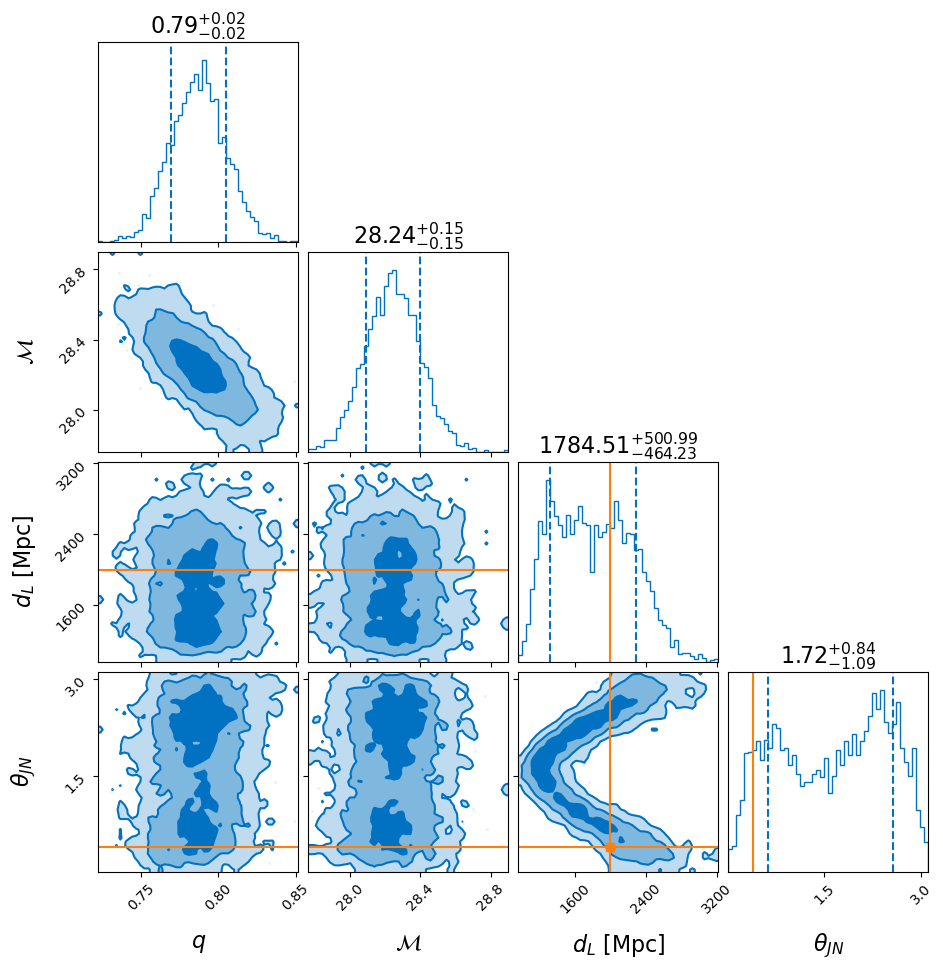

In [9]:
# Make a corner plot.
result.plot_corner()
